In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed = 42

import seaborn as sns

import pandas as pd

import matplotlib.pyplot as plt

import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

from keras_tuner import HyperParameters, Hyperband

from os.path import isfile

import lzma

import pickle

from jax import vmap, jit
import jax.numpy as jnp
import jax

from flax import linen as nn
from flax.training import train_state
import optax

import time

2021-12-03 00:23:29.489864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 00:23:29.489929: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**Импорт данных**

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

**Визуализация исходных данных**

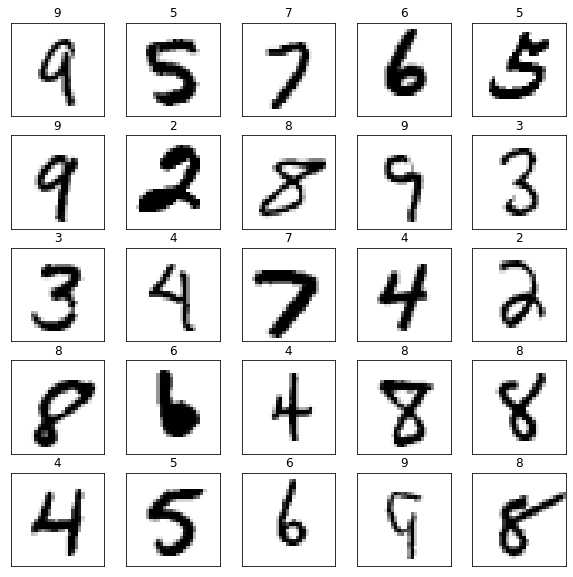

In [4]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
axs = ax.flatten()

letters_idx = np.random.randint(0, X_test.shape[0], len(axs))

for idx in range(len(axs)):
    axs[idx].imshow(X_test[letters_idx[idx]], cmap='gray_r')
    axs[idx].set_title(y_test[letters_idx[idx]])
    axs[idx].xaxis.set_ticks([])
    axs[idx].yaxis.set_ticks([])

plt.show()


In [5]:
width, height, depth = X_train.shape[1], X_train.shape[2], 1

X_train = X_train.reshape(X_train.shape[0], width, height, depth)
X_train = X_train.astype(np.float32)

X_test = X_test.reshape(X_test.shape[0], width, height, depth)
X_test = X_test.astype(np.float32)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Аугментация**

Мне показалось скучным работать с исходными данными - слишком они хороши. 

In [6]:
W_SHIFT = [-1, 1]
H_SHIFT = [-1, 1]
ROT_ANGLE = 20
ZOOM_RANGE = [0.7, 1.2]

In [7]:
BATCH_SIZE = 32
P_WIDTH = 28
P_HEIGHT = 28
P_DEPTH = 1
N_CLASSES = 10
NUM_EPOCHS = 3

Я много раз читал о создании валидационного датасета, который является частью тренировочного. Лучше один раз сделать, чем сто раз прочитать.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train)

В принципе, генератор можно настроить на разделение датасета. Чтобы не делать несколько отдельных. Но мне показалось так интереснее. Серьезного обоснования такому решению нет.

In [9]:
train_generator = ImageDataGenerator(
    width_shift_range=W_SHIFT, 
    height_shift_range=H_SHIFT,
    rotation_range=ROT_ANGLE,
    zoom_range=ZOOM_RANGE,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale= 1.0/255.0
)

train_generator.fit(X_train)
train_iterator = train_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [10]:
val_generator = ImageDataGenerator(
    width_shift_range=W_SHIFT, 
    height_shift_range=H_SHIFT,
    rotation_range=ROT_ANGLE,
    zoom_range=ZOOM_RANGE,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale= 1.0/255.0
)

val_generator.fit(X_val)
val_iterator = val_generator.flow(X_val, y_val, batch_size=BATCH_SIZE)

In [11]:
test_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale=1.0/255.0
)

test_generator.fit(X_test)
test_iterator = test_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)

**Визуализация аугментированных данных**

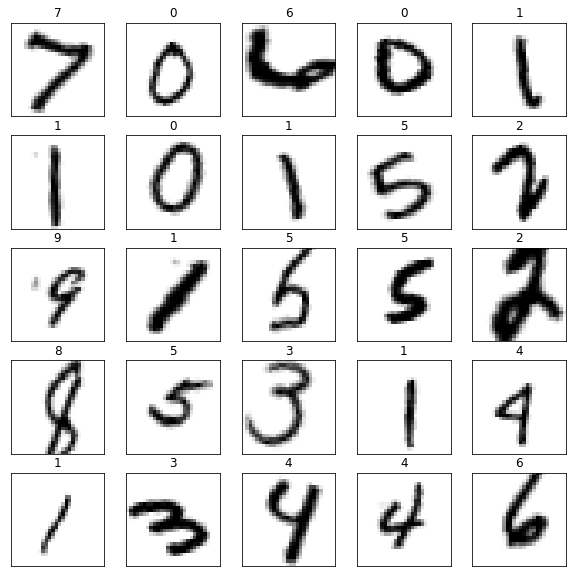

In [12]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
axs = ax.flatten()

for idx in range(len(axs)):
    letter_idx = round(letters_idx[idx]/BATCH_SIZE)
    random_bath_idx = random.choice(range(BATCH_SIZE))
    
    axs[idx].imshow(train_iterator[letter_idx][0][random_bath_idx], cmap='gray_r')
    
    img_label = np.nonzero(train_iterator[letter_idx][1][random_bath_idx])
    
    axs[idx].set_title(int(img_label[0]))
    axs[idx].xaxis.set_ticks([])
    axs[idx].yaxis.set_ticks([])

plt.show()

**Модель**

У меня нет серьезного обоснования, почему я взял именно такую структуру. Это некоторая комбинация изученных примеров и моего понимания свёрточных сетей.

In [13]:
def build_keras_model(hp):
    
    hp_filters_l1 = hp.Int(name='filters L1', min_value=16, max_value=128, step=16, default=32)
    hp_filters_l2 = hp.Int(name='filters L2', min_value=16, max_value=128, step=16, default=64)
    hp_weights = hp.Choice(name='kernel_initializer', values=['he_uniform', 'he_normal', 'normal', 'uniform', 'glorot_uniform', 'glorot_normal'], default='he_uniform')
    hp_funcs = hp.Choice(name='activation', values=['relu', 'sigmoid', 'tanh'], default='relu')
    hp_units = hp.Int(name='units', min_value=64, max_value=2048, step=64, default=128) 
    hp_rates = hp.Float(name='rate', min_value=0.0, max_value=0.5, step=0.05, default=0.25)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-3)

    model = Sequential()

    model.add(Input((width, height, depth)))

    model.add(Conv2D(filters=hp_filters_l1, kernel_size=(3, 3), activation=hp_funcs, kernel_initializer=hp_weights, padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    #model.add(BatchNormalization())

    model.add(Conv2D(filters=hp_filters_l2, kernel_size=(3, 3), activation=hp_funcs, kernel_initializer=hp_weights, padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    #model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dense(units=hp_units, activation=hp_funcs, kernel_initializer=hp_weights))
    model.add(Dropout(rate=hp_rates))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
def make_dataset_from_iterator(steps_count = 0, jax = True, iterator = None):
    """Generates dataset from ImageDataGenerator"""

    iterator.reset()

    result = [[], []]

    if jax:
        result = {
            'image': [], 
            'label': []
        }

    for _ in range(steps_count):
        batch_ds = tf.data.Dataset.from_generator(
            lambda: iterator,
            output_types=(tf.float32, tf.float32),
            output_shapes=(
                [BATCH_SIZE, P_WIDTH, P_HEIGHT, P_DEPTH],
                [BATCH_SIZE, N_CLASSES]
            )
        )

        temp_ds_iterator = iter(batch_ds)
        batch = next(temp_ds_iterator)

        if jax:
            result['image'].append(tfds.as_numpy(batch[0]))
            result['label'].append(np.argmax(tfds.as_numpy(batch[1]), axis=1))
        else:
            result[0].append(np.float32(tfds.as_numpy(batch[0])))
            result[1].append(np.float32(tfds.as_numpy(batch[1])))
    
    if jax:
        result['image'] = jnp.float32(np.array(result['image']).reshape(steps_count * BATCH_SIZE, P_WIDTH, P_HEIGHT, P_DEPTH))
        result['label'] = jnp.float32(np.array(result['label']).flatten())
        return result
    else:
        return np.array(result[0]).reshape(steps_count * BATCH_SIZE, P_WIDTH, P_HEIGHT, P_DEPTH), np.array(result[1]).reshape(steps_count * BATCH_SIZE, N_CLASSES)


In [15]:
STEP_SIZE_TRAIN = train_iterator.n // train_iterator.batch_size
STEP_SIZE_VAL = val_iterator.n // val_iterator.batch_size
STEP_SIZE_TEST = test_iterator.n // test_iterator.batch_size

In [16]:
X_train_ds, y_train_ds = make_dataset_from_iterator(STEP_SIZE_TRAIN, False, train_iterator)
X_val_ds, y_val_ds = make_dataset_from_iterator(STEP_SIZE_VAL, False, val_iterator)
X_test_ds, y_test_ds = make_dataset_from_iterator(STEP_SIZE_TEST, False, test_iterator)


2021-12-03 00:23:40.588427: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-03 00:23:40.588480: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-03 00:23:40.588502: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-LDSDKNA): /proc/driver/nvidia/version does not exist


In [17]:
# train_iterator.reset()
# val_iterator.reset()

In [18]:
keras_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, mode='min', verbose=1)

Для начала натренирую сетку с дефолтными параметрами.

In [19]:
keras_model = None
keras_history = None

if isfile("./models/keras_model.hdf5"):
    keras_model = load_model("./models/keras_model.hdf5")
    
    with lzma.open("./models/keras_history.xz", "rb") as m_file:
        keras_history = pickle.load(m_file)
else:
    keras_model = build_keras_model(HyperParameters())
    keras_history = keras_model.fit(
        x=X_train_ds, y=y_train_ds,#train_iterator, 
        epochs=NUM_EPOCHS, 
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=(X_val_ds, y_val_ds),#val_iterator,
        validation_steps=STEP_SIZE_VAL, 
        callbacks=[keras_early_stop]
        )
  
    keras_model.save("./models/keras_model.hdf5")

    with lzma.open("./models/keras_history.xz", "wb") as m_file:
        pickle.dump(keras_history.history, m_file)

    keras_history = keras_history.history

Epoch 1/3
1500/1500 [==============================] - 32s 21ms/step - loss: 0.3590 - accuracy: 0.8903 - val_loss: 0.0963 - val_accuracy: 0.9697
Epoch 2/3
1500/1500 [==============================] - 36s 24ms/step - loss: 0.1294 - accuracy: 0.9596 - val_loss: 0.0926 - val_accuracy: 0.9717
Epoch 3/3
1500/1500 [==============================] - 36s 24ms/step - loss: 0.0921 - accuracy: 0.9722 - val_loss: 0.0690 - val_accuracy: 0.9789


И теперь попробую подобрать гиперпараметры.

In [20]:
# keras_tuner = Hyperband(
#     hypermodel=build_keras_model,
#     objective='val_accuracy',
#     factor=3,
#     max_epochs=10,
#     directory='./tf_data', 
#     project_name='HW14'
# )

In [21]:
#keras_tuner_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, mode='min', verbose=1)

In [22]:
# train_iterator.reset()
# val_iterator.reset()

In [23]:
# keras_tuner.search(
#     train_iterator,
#     validation_data=val_iterator,
#     callbacks=[keras_tuner_early_stop]
#     )

In [24]:
# best_tuned_parameters = keras_tuner.get_best_hyperparameters()[0]

In [25]:
# train_iterator.reset()
# val_iterator.reset()

In [26]:
# best_tuned_model = None
# best_tuned_history = None

# if isfile("./models/keras_tuned_model.hdf5"):
#     best_tuned_model = load_model("./models/keras_tuned_model.hdf5")
    
#     with lzma.open("./models/keras_tuned_history.xz", "rb") as m_file:
#         best_tuned_history = pickle.load(m_file)
# else:
#     best_tuned_model = build_keras_model(best_tuned_parameters)
#     best_tuned_history = best_tuned_model.fit(
#         train_iterator, 
#         epochs=10, 
#         steps_per_epoch=STEP_SIZE_TRAIN,
#         validation_data=val_iterator,
#         validation_steps=STEP_SIZE_VAL, 
#         callbacks=[keras_early_stop]
#         )
  
#     best_tuned_model.save("./models/keras_tuned_model.hdf5")

#     with lzma.open("./models/keras_tuned_history.xz", "wb") as m_file:
#         pickle.dump(best_tuned_history.history, m_file)

In [27]:
def plot_history(hist: dict):
    fig, ax = plt.subplots(2,1, figsize=(18, 10))

    ax[0].plot(hist['loss'], color='b', label="Training loss")
    ax[0].plot(hist['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(hist['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(hist['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

    plt.show()

In [28]:
# plot_history(best_tuned_history)

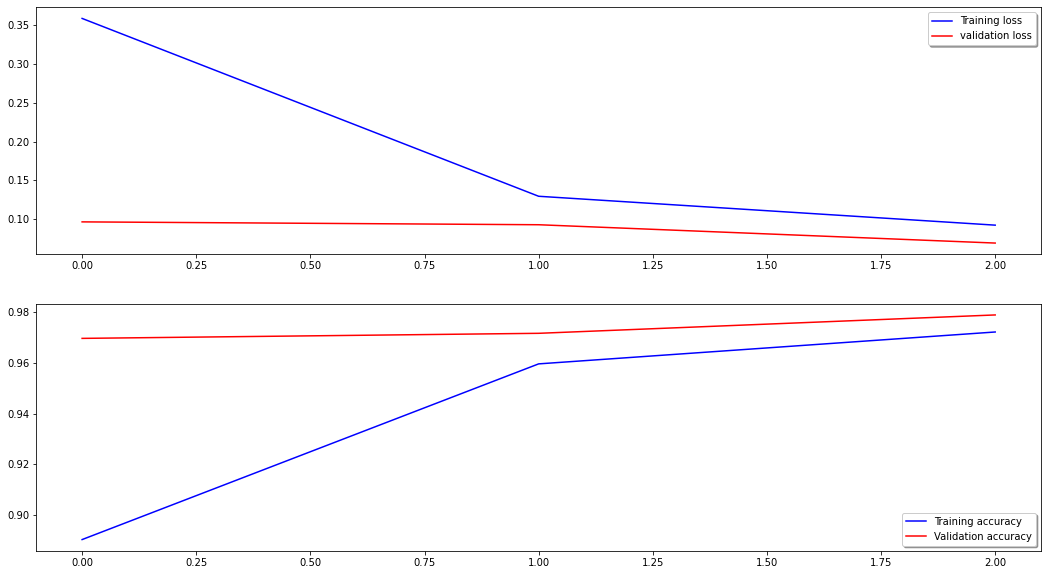

In [29]:
plot_history(keras_history)

In [30]:
def evaluate_model(in_model: None, iterator: None, print_result=False):
    step_size = iterator.n // iterator.batch_size
    verb = -1

    if print_result:
        verb = 1

    iterator.reset()

    ls, acc = in_model.evaluate(iterator, steps=step_size, verbose=verb)

    if print_result:
        print("Loss:\t\t{:.6f}\nAccuracy:\t{:.6f}".format(ls, acc))
    else:
        return ls, acc


In [31]:
# evaluate_model(best_tuned_model, test_iterator, True)

In [32]:
evaluate_model(keras_model, test_iterator, True)

312/312 [==============================] - 3s 10ms/step - loss: 0.0319 - accuracy: 0.9893
Loss:		0.031913
Accuracy:	0.989283


Тренированая модель показала худшую точность, что не радует. Но обучилась на две эпохи быстрее.

**Реальные цифры**

In [33]:
true_img_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale=1.0/255.0
)

#test_generator.fit(X_test)
true_img_iterator = true_img_generator.flow_from_directory(
    directory="./data",
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=1,
    class_mode="categorical"
)

Found 10 images belonging to 10 classes.


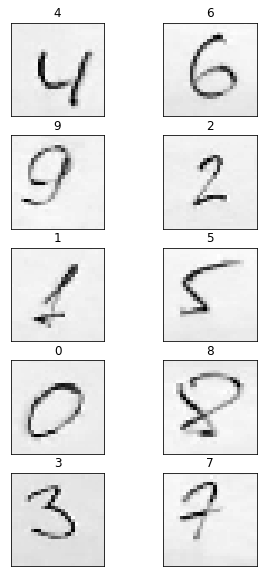

In [34]:
true_img_iterator.reset()

fig, ax = plt.subplots(5, 2, figsize=(5, 10))
axs = ax.flatten()

for idx in range(len(axs)):
    axs[idx].imshow(np.reshape(true_img_iterator[idx][0], (28, 28, 1)), cmap='gray_r')
    #axs[idx].imshow(true_img_iterator[idx][0])
    
    img_label = np.nonzero(true_img_iterator[idx][1][0])
    
    axs[idx].set_title(int(img_label[0]))

    axs[idx].xaxis.set_ticks([])
    axs[idx].yaxis.set_ticks([])

plt.show()

Тут интересно, что фон не такой чистый и вобще цифры немного отличаются по масштабу и повороту. Отлично, это возможность проверить влияние аугментации.

In [35]:
# true_img_iterator.reset()

# evaluate_model(best_tuned_model, true_img_iterator, True)

In [36]:
true_img_iterator.reset()

evaluate_model(keras_model, true_img_iterator, True)

10/10 [==============================] - 0s 3ms/step - loss: 0.5500 - accuracy: 0.9000
Loss:		0.550009
Accuracy:	0.900000


Loss на тренированной модели меньше. 

In [37]:
# true_img_iterator.reset()

# fig, ax = plt.subplots(5, 2, figsize=(5, 10))
# axs = ax.flatten()

# for idx in range(len(true_img_iterator)):
#     best_model_predict = best_tuned_model.predict(true_img_iterator[idx][0]).argmax(-1)
#     keras_model_predict = keras_model.predict(true_img_iterator[idx][0]).argmax(-1)
#     ground_true = np.nonzero(true_img_iterator[idx][1])[1]

#     axs[idx].imshow(np.reshape(true_img_iterator[idx][0], (28, 28, 1)), cmap='gray_r')
    
#     axs[idx].set_title("True: {}\nBest trained: {}\n Keras {}".format(ground_true, best_model_predict, keras_model_predict))

#     axs[idx].xaxis.set_ticks([])
#     axs[idx].yaxis.set_ticks([])

# plt.tight_layout(pad=2.0)
# plt.show()

Как видно, семерка вобще не хочет определяться. Можно бы было перетренировать модели, но я не вижу в этом смысла. Предварительно могу сказать, это связанно с тем, что в датасете почти все семерки без горизонтальной линии.

**Заключение**

Чем сетка проще, тем лучше. Inference быстрее, обучение быстрее. Тот случай, когда кашу маслом легко испортить. Как показал эксперимент точность может упасть вместе с производительностью, что печально.

Подбор гиперпараметров тут тоже не панацея. Сетки нужно понимать.

Аугментация данных важный момент. Для картинок точно. Сетка без аугментации половину реальных цифр не узнала (этот эксперимент я не сохранил). 

Важность ранней остановки трудно недооценить. Это не только время, но и переобучение. Можно оставить сетку учится и не заметить, где она в оверфит ушла. 

Вобще callbacks это must have технология для применения в нейронках.

Tensorflow порадовал сохранением данных самостоятельно. Можно прервать обучение и не проводить его заново с нуля - очень удобно.

Большой (возможно единственный), конечно, минус нейронок это скорость. Что обучения, что inference. Но, безусловно, нелинейность заложенная изначально в саму идею творит чудеса.

# **P.S. Flax**

Никакой моей заслуги в приведенном ниже коде нет, это совсем немного переделанный тутор <a href = https://flax.readthedocs.io/en/latest/notebooks/annotated_mnist.html>Annotated MNIST</a>.<br>
Просто мне стало интересно сравнить производительность.

In [38]:
train_ds = make_dataset_from_iterator(STEP_SIZE_TRAIN, True, train_iterator)
val_ds = make_dataset_from_iterator(STEP_SIZE_VAL, True, val_iterator)
test_ds = make_dataset_from_iterator(STEP_SIZE_TEST, True, test_iterator)

In [39]:
TRAIN_DS_SIZE = len(train_ds['image'])

In [40]:
class CNN(nn.Module):

    @nn.compact
    def __call__(self, x_in):
        x = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(x_in)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=N_CLASSES)(x)
        x = nn.log_softmax(x)
        return x

def cross_entropy_loss(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=N_CLASSES)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

def compute_metrics(*, logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

def create_train_state(rng, learning_rate, momentum):
    cnn = CNN()
    params = cnn.init(rng, jnp.ones([1, P_WIDTH, P_HEIGHT, P_DEPTH]))['params']
    tx = optax.sgd(learning_rate, momentum)
    
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

@jit
def train_step(state, batch):
    def loss_fn(params):
        logits = CNN().apply({'params': params}, batch['image'])
        loss = cross_entropy_loss(logits=logits, labels=batch['label'])
        
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=batch['label'])
    
    return state, metrics

@jit
def eval_step(params, batch):
    logits = CNN().apply({'params': params}, batch['image'])
    return compute_metrics(logits=logits, labels=batch['label'])


def train_epoch(state, train_ds, batch_size, epoch, rng):
    #train_ds_size = len(train_ds['image'])
    steps_per_epoch = STEP_SIZE_TRAIN#train_ds_size // batch_size

    perms = jax.random.permutation(rng, TRAIN_DS_SIZE)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
        }

    #print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, epoch_metrics_np['loss'], ))
    train_metrics = [epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100]

    return train_metrics, state

def eval_model(params, test_ds):
    metrics = eval_step(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']


In [41]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

learning_rate = 0.1
momentum = 0.9

state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [42]:
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    rng, input_rng = jax.random.split(rng)

    train_metrics, state = train_epoch(state, train_ds, BATCH_SIZE, epoch, input_rng)
    test_loss, test_accuracy = eval_model(state.params, val_ds)

    #print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100))
    print("Epoch #{}: {:.1f}s\ttrain loss: {:.5f}\t train acc: {:.5f}\ttest loss: {:.5f}\t test acc: {:.5f}".format(
      str(epoch), (time.time() - start_time), train_metrics[0], train_metrics[1], test_loss, test_accuracy
    ))

Epoch #1: 35.7s	train loss: 0.83991	 train acc: 75.11042	test loss: 0.69199	 test acc: 0.79308
Epoch #2: 37.6s	train loss: 0.75820	 train acc: 78.95625	test loss: 0.77149	 test acc: 0.76283
Epoch #3: 36.4s	train loss: 0.85329	 train acc: 75.98959	test loss: 1.16777	 test acc: 0.77592
